## Grokking Analysis

In [12]:
import tensorflow as tf
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from estimators.smi_estimator import compute_smi

tf.keras.utils.set_random_seed(42)

### Create Dataset and Model

In [2]:
def create_data(p, train_fraction, batch_size):
    data = []
    for i in range(p):
        for j in range(p):
            # Modular addition
            data.append([i, j, (i + j) % p])
    data = np.array(data)

    # Split into train and test
    np.random.shuffle(data)
    train_data = data[:int(len(data) * train_fraction)]
    test_data = data[int(len(data) * train_fraction):]

    # Create datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(train_data[:,0], axis=1), np.expand_dims(train_data[:,1], axis=1), np.expand_dims(train_data[:,2], axis=1)))
    test_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(test_data[:,0], axis=1), np.expand_dims(test_data[:,1], axis=1), np.expand_dims(test_data[:,2], axis=1)))

    # Create dataloaders with batch size
    train_loader = train_dataset.shuffle(len(train_data)).batch(batch_size)
    test_loader = test_dataset.batch(batch_size)
    return train_loader, test_loader

def toy_model(p, d_embed, d_hidden):
    x1 = tf.keras.Input(shape=(1,))
    x2 = tf.keras.Input(shape=(1,))
    e1 = tf.keras.layers.Embedding(p, d_embed)(x1)
    e2 = tf.keras.layers.Embedding(p, d_embed)(x2)
    x = tf.keras.layers.Concatenate(axis=1)([tf.keras.layers.Flatten()(e1), tf.keras.layers.Flatten()(e2)])
    x = tf.keras.layers.Dense(d_hidden, activation='relu')(x)
    x = tf.keras.layers.Dense(p)(x)
    model = tf.keras.Model(inputs=[x1, x2], outputs=x)
    return model

### Train Model

In [3]:
for train_fraction in [0.3,0.4,0.5]:
    p = 53
    d_embed = 128
    d_hidden = 256

    n_epochs = 4000
    learning_rate = 0.001
    weight_decay = 1
    batch_size = 256
    n_projs = 1000

    report_interval = 20
    save_interval = 50

    save_folder = f'../results/Grokking/test/batch_size_{batch_size}/tf_{train_fraction}'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    train_loader, test_loader = create_data(p, train_fraction, batch_size)
    model = toy_model(p, d_embed, d_hidden)

    criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.AdamW(learning_rate, weight_decay)

    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    trn_acc_fn = tf.keras.metrics.SparseCategoricalAccuracy()
    tst_acc_fn = tf.keras.metrics.SparseCategoricalAccuracy()

    total_loss = 0
    batches = 0
    for x1, x2, y in train_loader:
        preds = model([x1, x2], training=False)
        loss = loss_fn(y, preds)
        total_loss += loss.numpy()
        batches += 1
        trn_acc_fn.update_state(y, preds)
    trn_loss = total_loss / batches
    trn_acc = trn_acc_fn.result().numpy()

    total_loss = 0
    batches = 0
    for x1, x2, y in test_loader:
        preds = model([x1, x2], training=False)
        loss = loss_fn(y, preds)
        total_loss += loss.numpy()
        batches += 1
        tst_acc_fn.update_state(y, preds)
    tst_loss = total_loss / batches
    tst_acc = tst_acc_fn.result().numpy()

    print(f"0000/{n_epochs}: Train loss={trn_loss:.4f}, acc={trn_acc*100:.1f}%  /  Test loss={tst_loss:.4f}, acc={tst_acc*100:.1f}%")

    if not os.path.exists(f"{save_folder}/saved_models"):
        os.makedirs(f"{save_folder}/saved_models")
    model.save(f"{save_folder}/saved_models/model_0000.keras")

    for epoch in range(n_epochs):

        # Training phase
        train_loss = tf.keras.metrics.Mean()
        train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        for x1, x2, y in train_loader:
            with tf.GradientTape() as tape:
                output = model([x1, x2])
                loss = criterion(y, output)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_loss.update_state(loss)
            train_acc.update_state(y, output)

        train_loss_history.append(train_loss.result().numpy())
        train_acc_history.append(train_acc.result().numpy())

        # Testing phase
        test_loss = tf.keras.metrics.Mean()
        test_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        for x1, x2, y in test_loader:
            output = model([x1, x2])
            loss = criterion(y, output)

            test_loss.update_state(loss)
            test_acc.update_state(y, output)

        test_loss_history.append(test_loss.result().numpy())
        test_acc_history.append(test_acc.result().numpy())

        if (epoch+1) % report_interval == 0:
            print(f"{epoch+1:04}/{n_epochs}: Train loss={train_loss.result().numpy():.4f}, acc={train_acc.result().numpy()*100:.1f}%  /  Test loss={test_loss.result().numpy():.4f}, acc={test_acc.result().numpy()*100:.1f}%")
            
        if (epoch+1) % save_interval == 0:
            model.save(f"{save_folder}/saved_models/model_{epoch+1:04}.keras")

    results = {}
    results['train_loss'] = [trn_loss] + train_loss_history
    results['test_loss'] = [tst_loss] + test_loss_history
    results['train_acc'] = [trn_acc] + train_acc_history
    results['test_acc'] = [tst_acc] + test_acc_history

    with open(f"{save_folder}/metrics.pkl", 'wb') as f:
        pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

2024-07-01 16:14:42.285049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78823 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


0000/4000: Train loss=3.9700, acc=1.9%  /  Test loss=3.9704, acc=2.0%


2024-07-01 16:14:45.164381: I external/local_xla/xla/service/service.cc:168] XLA service 0x5586a211c220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 16:14:45.164419: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-07-01 16:14:45.170802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 16:14:45.217127: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
I0000 00:00:1719850485.359042 2380085 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0020/4000: Train loss=3.6044, acc=13.9%  /  Test loss=4.1699, acc=0.0%
0040/4000: Train loss=2.5366, acc=37.8%  /  Test loss=5.3069, acc=0.0%
0060/4000: Train loss=1.7303, acc=62.5%  /  Test loss=6.7703, acc=0.0%
0080/4000: Train loss=1.1868, acc=86.8%  /  Test loss=7.8620, acc=0.0%
0100/4000: Train loss=0.8351, acc=98.3%  /  Test loss=8.6937, acc=0.0%
0120/4000: Train loss=0.5950, acc=99.9%  /  Test loss=9.2483, acc=0.0%
0140/4000: Train loss=0.4699, acc=100.0%  /  Test loss=9.5839, acc=0.0%
0160/4000: Train loss=0.3725, acc=100.0%  /  Test loss=9.7461, acc=0.0%
0180/4000: Train loss=0.3193, acc=100.0%  /  Test loss=9.8149, acc=0.0%
0200/4000: Train loss=0.2855, acc=100.0%  /  Test loss=9.8200, acc=0.0%
0220/4000: Train loss=0.2584, acc=100.0%  /  Test loss=9.8030, acc=0.0%
0240/4000: Train loss=0.2360, acc=100.0%  /  Test loss=9.7630, acc=0.0%
0260/4000: Train loss=0.2186, acc=100.0%  /  Test loss=9.7435, acc=0.0%
0280/4000: Train loss=0.2038, acc=100.0%  /  Test loss=9.7164, acc=0.0

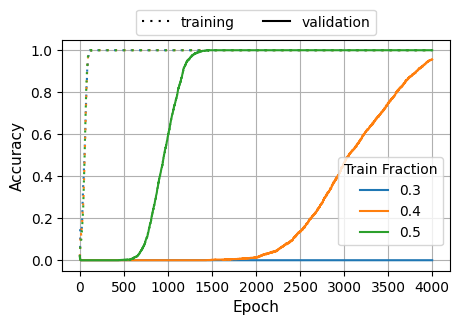

In [29]:
batch_size = 256
p = 53

test_acc = []
train_acc = []
for train_fraction in [0.3,0.4,0.5]:
    save_folder = f'../results/Grokking/test/batch_size_{batch_size}/tf_{train_fraction}'
    with open(f"{save_folder}/metrics.pkl", 'rb') as f:
        metrics = pickle.load(f)
    test_acc.append(metrics['test_acc'])
    train_acc.append(metrics['train_acc'])
    
plt.figure(figsize=(5,3), dpi=100)
plt.plot(range(0,4001), test_acc[0], c='tab:blue', label='0.3')
plt.plot(range(0,4001), train_acc[0], c='tab:blue', ls=(0, (1, 3)))
plt.plot(range(0,4001), test_acc[1], c='tab:orange', label='0.4')
plt.plot(range(0,4001), train_acc[1], c='tab:orange', ls=(0, (1, 3)))
plt.plot(range(0,4001), test_acc[2], c='tab:green', label='0.5')
plt.plot(range(0,4001), train_acc[2], c='tab:green', ls=(0, (1, 3)))
first_legend = plt.legend(loc='lower right', title='Train Fraction', bbox_to_anchor=(1, 0.08), fontsize=10)
plt.gca().add_artist(first_legend)
plt.grid(True)
plt.ylabel('Accuracy', fontsize=11)
plt.xlabel('Epoch', fontsize=11)

line_1 = Line2D([0],[0], color='black', ls=(0, (1, 3)))
line_2 = Line2D([0],[0], color='black')
labels = ['training', 'validation']
plt.legend([line_1, line_2], labels, loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.16))

### Compute SMI

In [8]:
for train_fraction in [0.3,0.4,0.5]:
    print(f'Train fraction: {train_fraction}')
    p = 53
    
    n_epochs = 4001
    batch_size = 256

    save_folder = f'../results/Grokking/test/batch_size_{batch_size}/tf_{train_fraction}'

    train_loader, test_loader = create_data(p, train_fraction, batch_size)

    smi_ty_history = []
    smi_xt_history = []
    epoch_list = [epoch for epoch in range(n_epochs)
                  if (epoch <= 1000 and epoch % 50 == 0) or
                  (1000 < epoch <= 2000 and epoch % 100 == 0) or
                  (2000 < epoch <= 3000 and epoch % 150 == 0) or
                  (3000 < epoch <= 4000 and epoch % 200 == 0)]

    for epoch in range(n_epochs):
        if epoch in epoch_list:
            model = tf.keras.models.load_model(f"{save_folder}/saved_models/model_{epoch:04}.keras")
            # Training phase
            all_x1 = []
            all_x2 = []
            all_y = []
            for x1, x2, y in train_loader:
                all_x1.extend(x1.numpy())
                all_x2.extend(x2.numpy())
                all_y.extend(y.numpy())
            for x1, x2, y in test_loader:
                all_x1.extend(x1.numpy())
                all_x2.extend(x2.numpy())
                all_y.extend(y.numpy())

            int_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
            activity = int_model.predict([np.array(all_x1), np.array(all_x2)], verbose=0)
            smi_ty = compute_smi(activity, np.array(all_y), proj_x=True, proj_y=False, n_projs=1000, method='ksg_cd')
            smi_xt = compute_smi(activity, np.array(all_x1), proj_x=True, proj_y=False, n_projs=1000, method='ksg_cd')
            smi_ty_history.append(smi_ty)
            smi_xt_history.append(smi_xt)

            print(f"{epoch}/{n_epochs}: SMI(T;Y): {smi_ty:.3f}, SMI(X;T): {smi_xt:.3f}")

    smi_ty_history = np.array(smi_ty_history)
    smi_xt_history = np.array(smi_xt_history)
    
    results =  {}
    results['smi_ty'] = smi_ty_history
    results['smi_xt'] = smi_xt_history

    with open(f"{save_folder}/smi", 'wb') as f:
        pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

Train fraction: 0.3
0/4001: SMI(T;Y): 0.019, SMI(X;T): 0.281
50/4001: SMI(T;Y): 0.018, SMI(X;T): 0.336
100/4001: SMI(T;Y): 0.017, SMI(X;T): 0.326
150/4001: SMI(T;Y): 0.019, SMI(X;T): 0.316
200/4001: SMI(T;Y): 0.017, SMI(X;T): 0.316
250/4001: SMI(T;Y): 0.019, SMI(X;T): 0.311
300/4001: SMI(T;Y): 0.019, SMI(X;T): 0.316
350/4001: SMI(T;Y): 0.018, SMI(X;T): 0.308
400/4001: SMI(T;Y): 0.018, SMI(X;T): 0.315
450/4001: SMI(T;Y): 0.019, SMI(X;T): 0.304
500/4001: SMI(T;Y): 0.018, SMI(X;T): 0.303
550/4001: SMI(T;Y): 0.019, SMI(X;T): 0.304
600/4001: SMI(T;Y): 0.020, SMI(X;T): 0.307
650/4001: SMI(T;Y): 0.018, SMI(X;T): 0.301
700/4001: SMI(T;Y): 0.019, SMI(X;T): 0.305
750/4001: SMI(T;Y): 0.020, SMI(X;T): 0.300
800/4001: SMI(T;Y): 0.019, SMI(X;T): 0.302
850/4001: SMI(T;Y): 0.018, SMI(X;T): 0.303
900/4001: SMI(T;Y): 0.019, SMI(X;T): 0.308
950/4001: SMI(T;Y): 0.020, SMI(X;T): 0.303
1000/4001: SMI(T;Y): 0.019, SMI(X;T): 0.302
1100/4001: SMI(T;Y): 0.019, SMI(X;T): 0.301
1200/4001: SMI(T;Y): 0.019, SMI(X;T

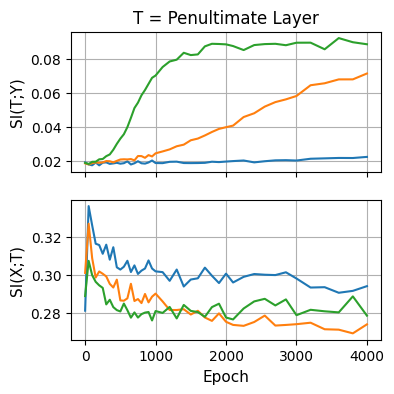

In [31]:
batch_size = 256
p = 53
n_epochs = 4000

epoch_list = [epoch for epoch in range(n_epochs+1)
              if (epoch <= 1000 and epoch % 50 == 0) or
              (1000 < epoch <= 2000 and epoch % 100 == 0) or
              (2000 < epoch <= 3000 and epoch % 150 == 0) or
              (3000 < epoch <= 4000 and epoch % 200 == 0)]

smi_ty = []
smi_xt = []

for train_fraction in [0.3,0.4,0.5]:
    with open(f"../results/Grokking/test/batch_size_{batch_size}/tf_{train_fraction}/smi", 'rb') as f:
        results = pickle.load(f)
    smi_ty.append(results['smi_ty'])
    smi_xt.append(results['smi_xt'])

fig, axs = plt.subplots(2,1, figsize=(4,4), dpi=100, sharex=True)
axs[0].plot(epoch_list,smi_ty[0])
axs[0].plot(epoch_list,smi_ty[1])
axs[0].plot(epoch_list,smi_ty[2],)
axs[0].grid(True)
axs[0].set_ylabel('SI(T;Y)', fontsize=11)
axs[0].set_title('T = Penultimate Layer')

axs[1].plot(epoch_list,smi_xt[0], label='0.3')
axs[1].plot(epoch_list,smi_xt[1], label='0.4')
axs[1].plot(epoch_list,smi_xt[2], label='0.5')
axs[1].grid(True)
axs[1].set_ylabel('SI(X;T)', fontsize=11)
axs[1].set_xlabel('Epoch', fontsize=11)
# axs[1].legend(ncols=2, title='Train Fraction')

plt.show()